# 04. Model Evaluation & Feature Importance Analysis

## 📋 Overview
Notebook ini melakukan **comprehensive evaluation** dari model terpilih, termasuk:
- Cross-validation untuk stability testing
- SHAP analysis untuk model interpretability
- Error analysis & misclassification patterns
- Threshold optimization untuk clinical deployment
- Final model selection & recommendations

### 🎯 Objectives:
1. Validate model stability dengan K-Fold Cross-Validation
2. Analyze feature importance menggunakan SHAP
3. Perform error analysis (understand failure cases)
4. Optimize classification threshold
5. Generate final recommendations untuk deployment

### 🔍 Analysis Components:
- **Stability Testing**: 5-Fold CV untuk generalization check
- **Interpretability**: SHAP values untuk explain predictions
- **Calibration**: Probability reliability analysis
- **Threshold**: Optimize untuk precision-recall trade-off
- **Production**: Deployment readiness assessment

### 📊 Expected Output:
- Cross-validation results & stability metrics
- Feature importance rankings (SHAP)
- Optimal classification threshold
- Final model recommendation
- Production deployment guide

---

**Author:** Muhammad Ichsan Junaedi & Amanda Wijayanti  
**Date:** December 2024  
**Institution:** STMIK TAZKIA

In [11]:
"""
CELL 2: Import Libraries & Setup
=================================
Import semua library untuk evaluation, SHAP analysis, dan visualization.
"""

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from datetime import datetime

# Deep Learning
import tensorflow as tf
from tensorflow import keras

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc,
    cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score,
    brier_score_loss, log_loss
)
from sklearn.calibration import calibration_curve

# SHAP for interpretability
import shap

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Plot configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 6)

print("="*70)
print("ENVIRONMENT SETUP - MODEL EVALUATION")
print("="*70)
print(f"\n✅ TensorFlow: {tf.__version__}")
print(f"✅ SHAP: {shap.__version__}")
print(f"✅ Random Seed: {RANDOM_SEED}")

print("\n💡 INFO: Libraries loaded for comprehensive evaluation")
print("💡 INFO: SHAP analysis will explain model predictions")
print("="*70 + "\n")

ENVIRONMENT SETUP - MODEL EVALUATION

✅ TensorFlow: 2.20.0
✅ SHAP: 0.49.1
✅ Random Seed: 42

💡 INFO: Libraries loaded for comprehensive evaluation
💡 INFO: SHAP analysis will explain model predictions



In [12]:
"""
CELL 3: Load Data & All Models
===============================
Load data dan semua model untuk comprehensive comparison.
"""

import pandas as pd
import json
import pickle
import numpy as np
from tensorflow import keras

print("="*70)
print("LOADING DATA & MODELS")
print("="*70)

# 1. Load preprocessed data
print("\n📂 Loading data...")
# Pastikan path sesuai struktur folder Anda
try:
    X_train = pd.read_csv('../data/processed/X_train.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
    X_test = pd.read_csv('../data/processed/X_test.csv')
    y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()
    print(f"✅ Data loaded: {X_train.shape[0]} train, {X_test.shape[0]} test samples")
except FileNotFoundError:
    print("❌ Error: Data files not found in ../data/processed/")

# 2. Load scaler
try:
    with open('../models/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    # Scale data
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("✅ Features scaled successfully")
except FileNotFoundError:
    print("⚠️  Scaler not found, using raw data (Not Recommended for DNN)")
    X_train_scaled = X_train
    X_test_scaled = X_test

# 3. Load models
print("\n📂 Loading models...")

# DNN Baseline
try:
    dnn_baseline = keras.models.load_model('../models/dnn_baseline_best.h5')
    print("✅ DNN Baseline loaded")
except OSError:
    print("⚠️  DNN Baseline model not found")
    dnn_baseline = None

# DNN Tuned
try:
    dnn_tuned = keras.models.load_model('../models/dnn_tuned.h5')
    print("✅ DNN Tuned loaded")
except OSError:
    print("⚠️  DNN Tuned model not found")
    dnn_tuned = None

# Random Forest (if available)
try:
    with open('../models/rf_model.pkl', 'rb') as f:
        rf_model = pickle.load(f)
    print("✅ Random Forest loaded")
    rf_available = True
except FileNotFoundError:
    print("⚠️  Random Forest model not found (will use metrics only)")
    rf_model = None
    rf_available = False

# 4. Load metrics for comparison (ROBUST EXTRACTION)
print("\n📂 Loading metrics...")

with open('../results/metrics/dnn_baseline_metrics.json', 'r') as f:
    baseline_metrics = json.load(f)

with open('../results/metrics/dnn_tuned_metrics.json', 'r') as f:
    tuned_metrics = json.load(f)

with open('../results/metrics/rf_metrics.json', 'r') as f:
    rf_metrics = json.load(f)

print("✅ All metrics loaded successfully")

# ==============================================================================
# HELPER: Safe Metric Extraction
# ==============================================================================
def get_val(data_dict, keys_list, default=0.0):
    """Helper untuk mengambil nilai metric secara aman (Case Insensitive)"""
    for k in keys_list:
        if k in data_dict:
            return float(data_dict[k])
    return default

# --- Prepare Metric Dictionaries (Flattening) ---

# A. Baseline Data
base_data = baseline_metrics.get('test_metrics', baseline_metrics)

# B. Tuned Data
tuned_data = tuned_metrics.get('test_metrics', tuned_metrics)

# C. Random Forest Data (Handle Nested Structure)
try:
    rf_data = rf_metrics['tuned_model_performance']['test']
except (KeyError, TypeError):
    rf_data = rf_metrics

# --- Extract ROC-AUC Safely ---
baseline_auc = get_val(base_data, ['ROC-AUC', 'roc_auc'])
tuned_auc    = get_val(tuned_data, ['ROC-AUC', 'roc_auc'])
rf_auc       = get_val(rf_data, ['ROC-AUC', 'roc_auc'])

# --- Extract Accuracy Safely (untuk display) ---
base_acc  = get_val(base_data, ['Accuracy', 'accuracy'])
tuned_acc = get_val(tuned_data, ['Accuracy', 'accuracy'])
rf_acc    = get_val(rf_data, ['Accuracy', 'accuracy'])

# --- Extract F1 Safely (untuk display) ---
base_f1  = get_val(base_data, ['F1-Score', 'f1_score'])
tuned_f1 = get_val(tuned_data, ['F1-Score', 'f1_score'])
rf_f1    = get_val(rf_data, ['F1-Score', 'f1_score'])

# 5. Select best model for detailed analysis
best_auc_val = max(baseline_auc, tuned_auc, rf_auc)

if tuned_auc == best_auc_val:
    best_model = dnn_tuned
    best_model_name = "DNN Tuned"
    best_acc = tuned_acc
    best_f1 = tuned_f1
elif baseline_auc == best_auc_val:
    best_model = dnn_baseline
    best_model_name = "DNN Baseline"
    best_acc = base_acc
    best_f1 = base_f1
else:
    best_model = rf_model if rf_available else dnn_tuned
    best_model_name = "Random Forest"
    best_acc = rf_acc
    best_f1 = rf_f1

print("\n" + "="*70)
print("🏆 BEST MODEL SELECTED FOR DETAILED ANALYSIS")
print("="*70)
print(f"\n   Model:    {best_model_name}")
print(f"   ROC-AUC:  {best_auc_val:.4f}")
print(f"   Accuracy: {best_acc:.4f}")
print(f"   F1-Score: {best_f1:.4f}")

print("\n💡 INFO: This model will be used for:")
print("   • Cross-validation analysis")
print("   • SHAP feature importance")
print("   • Error analysis")
print("   • Threshold optimization")

print("\n" + "="*70 + "\n")

LOADING DATA & MODELS

📂 Loading data...
✅ Data loaded: 1508 train, 377 test samples
✅ Features scaled successfully

📂 Loading models...
✅ DNN Baseline loaded


✅ DNN Tuned loaded
✅ Random Forest loaded

📂 Loading metrics...
✅ All metrics loaded successfully

🏆 BEST MODEL SELECTED FOR DETAILED ANALYSIS

   Model:    DNN Baseline
   ROC-AUC:  0.9364
   Accuracy: 0.8674
   F1-Score: 0.8884

💡 INFO: This model will be used for:
   • Cross-validation analysis
   • SHAP feature importance
   • Error analysis
   • Threshold optimization




In [13]:
"""
CELL 4: K-Fold Cross-Validation
======================================================
Test model stability across different data splits.
Includes auto-recovery for missing metrics.
"""

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import json
import os

print("="*70)
print("CROSS-VALIDATION ANALYSIS")
print("="*70)

print("""
🔍 CROSS-VALIDATION STRATEGY:
- Method: Stratified 5-Fold CV
  - Split data into 5 folds
  - Each fold maintains class distribution
  - Train on 4 folds, validate on 1
  - Repeat 5 times (each fold used once for validation)
""")

# ==============================================================================
# 1. SAFETY CHECK: DATA & MODEL
# ==============================================================================
if 'best_model' not in locals():
    print("⚠️  'best_model' not found in memory. Attempting to load Tuned Model...")
    try:
        best_model = keras.models.load_model('../models/dnn_tuned.h5')
        best_model_name = "DNN Tuned (Auto-Loaded)"
        print("✅ Model loaded successfully.")
    except:
        raise ValueError("❌ CRITICAL: No model found. Please run Cell 3 first!")

# Ensure data types are correct for TensorFlow
if isinstance(X_train_scaled, pd.DataFrame):
    X_train_arr = X_train_scaled.values.astype('float32')
    X_test_arr = X_test_scaled.values.astype('float32')
else:
    X_train_arr = X_train_scaled.astype('float32')
    X_test_arr = X_test_scaled.astype('float32')

X_full = np.vstack([X_train_arr, X_test_arr])
y_full = np.concatenate([y_train, y_test]).astype('float32')

print(f"📊 Total samples for CV: {len(y_full):,}")

# Setup Stratified K-Fold
n_splits = 5
seed_val = 42
if 'RANDOM_SEED' in locals():
    seed_val = RANDOM_SEED

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_val)

print(f"\n🔄 Running {n_splits}-Fold Cross-Validation...")
print(f"   This will train the model {n_splits} times...")
print(f"   Estimated time: 2-5 minutes\n")

# Initialize result storage
cv_results = {
    'fold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'roc_auc': [],
    'balanced_acc': []
}

# Perform CV
fold_num = 1
start_time = datetime.now()

for train_idx, val_idx in skf.split(X_full, y_full):
    print(f"   Fold {fold_num}/{n_splits}...", end=' ')
    
    X_train_cv, X_val_cv = X_full[train_idx], X_full[val_idx]
    y_train_cv, y_val_cv = y_full[train_idx], y_full[val_idx]
    
    # ----------------------------------------------------------------------
    # ROBUST MODEL CLONING (Fixes NotImplementedError)
    # ----------------------------------------------------------------------
    if str(best_model_name).startswith("DNN"):
        # 1. Clone Arsitektur
        model_cv = keras.models.clone_model(best_model)
        
        # 2. Fresh Optimizer Instance
        opt_config = best_model.optimizer.get_config()
        new_optimizer = best_model.optimizer.__class__.from_config(opt_config)
        
        # 3. Fresh Compile (Hindari shared state metrics)
        model_cv.compile(
            optimizer=new_optimizer,
            loss='binary_crossentropy', 
            metrics=['accuracy'] 
        )
        
        # Train
        model_cv.fit(
            X_train_cv, y_train_cv,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        
        # Predict
        y_pred_proba = model_cv.predict(X_val_cv, verbose=0).ravel()
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Cleanup memory
        keras.backend.clear_session()
        
    else:
        # RF Handling
        from sklearn.base import clone
        model_cv = clone(best_model)
        model_cv.fit(X_train_cv, y_train_cv)
        y_pred_proba = model_cv.predict_proba(X_val_cv)[:, 1]
        y_pred = model_cv.predict(X_val_cv)
    
    # Calculate metrics
    cv_results['fold'].append(fold_num)
    cv_results['accuracy'].append(accuracy_score(y_val_cv, y_pred))
    cv_results['precision'].append(precision_score(y_val_cv, y_pred, zero_division=0))
    cv_results['recall'].append(recall_score(y_val_cv, y_pred, zero_division=0))
    cv_results['f1_score'].append(f1_score(y_val_cv, y_pred, zero_division=0))
    cv_results['roc_auc'].append(roc_auc_score(y_val_cv, y_pred_proba))
    cv_results['balanced_acc'].append(balanced_accuracy_score(y_val_cv, y_pred))
    
    print(f"✓ (AUC: {cv_results['roc_auc'][-1]:.4f})")
    fold_num += 1

end_time = datetime.now()
cv_time = (end_time - start_time).total_seconds()

print(f"\n✅ Cross-validation completed in {cv_time:.1f} seconds")

# Create results DataFrame
cv_df = pd.DataFrame(cv_results)

print("\n" + "="*70)
print("📊 CROSS-VALIDATION RESULTS")
print("="*70)
print("\n", cv_df.to_string(index=False))

# Calculate statistics
print("\n" + "="*70)
print("📈 STATISTICAL SUMMARY")
print("="*70)

stats_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Balanced Acc'],
    'Mean': [cv_df[c].mean() for c in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'balanced_acc']],
    'Std Dev': [cv_df[c].std() for c in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'balanced_acc']]
})

print("\n", stats_df.to_string(index=False))

# Stability assessment
mean_auc = cv_df['roc_auc'].mean()
std_auc = cv_df['roc_auc'].std()

print("\n" + "="*70)
print("🎯 STABILITY ASSESSMENT")
print("="*70)
print(f"\n📊 ROC-AUC Analysis:")
print(f"   Mean: {mean_auc:.4f}")
print(f"   Std Dev: {std_auc:.4f}")

if std_auc < 0.02:
    print("   Stability: ✅ EXCELLENT (Very stable)")
elif std_auc < 0.05:
    print("   Stability: ✅ GOOD (Acceptable)")
else:
    print("   Stability: ⚠️  MODERATE (High variance)")

print(f"\n📊 Comparison with Single Split:")

# Cek apakah best_metrics ada. Jika tidak, coba load dari JSON.
test_auc_val = None

if 'best_metrics' in locals():
    # Helper get_val (defined inline to be safe)
    def get_val_safe(d, keys):
        for k in keys: 
            if k in d: return float(d[k])
        return 0.0
    test_auc_val = get_val_safe(best_metrics, ['ROC-AUC', 'roc_auc'])
else:
    print("⚠️  'best_metrics' variable not found. Attempting to load from JSON...")
    try:
        # Coba load tuned metrics
        with open('../results/metrics/dnn_tuned_metrics.json', 'r') as f:
            data = json.load(f)
            test_auc_val = data['test_metrics']['roc_auc']
            print("   (Loaded Tuned DNN metrics for comparison)")
    except FileNotFoundError:
        try:
            # Fallback ke baseline
            with open('../results/metrics/dnn_baseline_metrics.json', 'r') as f:
                data = json.load(f)
                test_auc_val = data['test_metrics']['roc_auc']
                print("   (Loaded Baseline DNN metrics for comparison)")
        except:
            print("❌ Could not load metrics files. Comparison skipped.")

if test_auc_val is not None:
    print(f"   Test Set AUC: {test_auc_val:.4f}")
    print(f"   CV Mean AUC:  {mean_auc:.4f}")
    print(f"   Difference:   {abs(test_auc_val - mean_auc):.4f}")

    if abs(test_auc_val - mean_auc) < 0.02:
        print(f"   ✅ Single split representative of overall performance")
    else:
        print(f"   ⚠️  Single split may not be fully representative")

print("\n" + "="*70)
print("💡 INFO: Low std dev indicates model generalizes consistently")
print("="*70 + "\n")

CROSS-VALIDATION ANALYSIS

🔍 CROSS-VALIDATION STRATEGY:
- Method: Stratified 5-Fold CV
  - Split data into 5 folds
  - Each fold maintains class distribution
  - Train on 4 folds, validate on 1
  - Repeat 5 times (each fold used once for validation)

📊 Total samples for CV: 1,885

🔄 Running 5-Fold Cross-Validation...
   This will train the model 5 times...
   Estimated time: 2-5 minutes

   Fold 1/5... ✓ (AUC: 0.9025)
   Fold 2/5... ✓ (AUC: 0.8953)
   Fold 3/5... ✓ (AUC: 0.8613)
   Fold 4/5... ✓ (AUC: 0.9281)
   Fold 5/5... ✓ (AUC: 0.9138)

✅ Cross-validation completed in 26.9 seconds

📊 CROSS-VALIDATION RESULTS

  fold  accuracy  precision   recall  f1_score  roc_auc  balanced_acc
    1  0.835544   0.894977 0.834043  0.863436 0.902517      0.836035
    2  0.814324   0.869955 0.825532  0.847162 0.895265      0.810653
    3  0.803714   0.860987 0.817021  0.838428 0.861313      0.799356
    4  0.846154   0.904110 0.842553  0.872247 0.928139      0.847333
    5  0.851459   0.912442 0.8425

📊 VISUALIZING CROSS-VALIDATION RESULTS



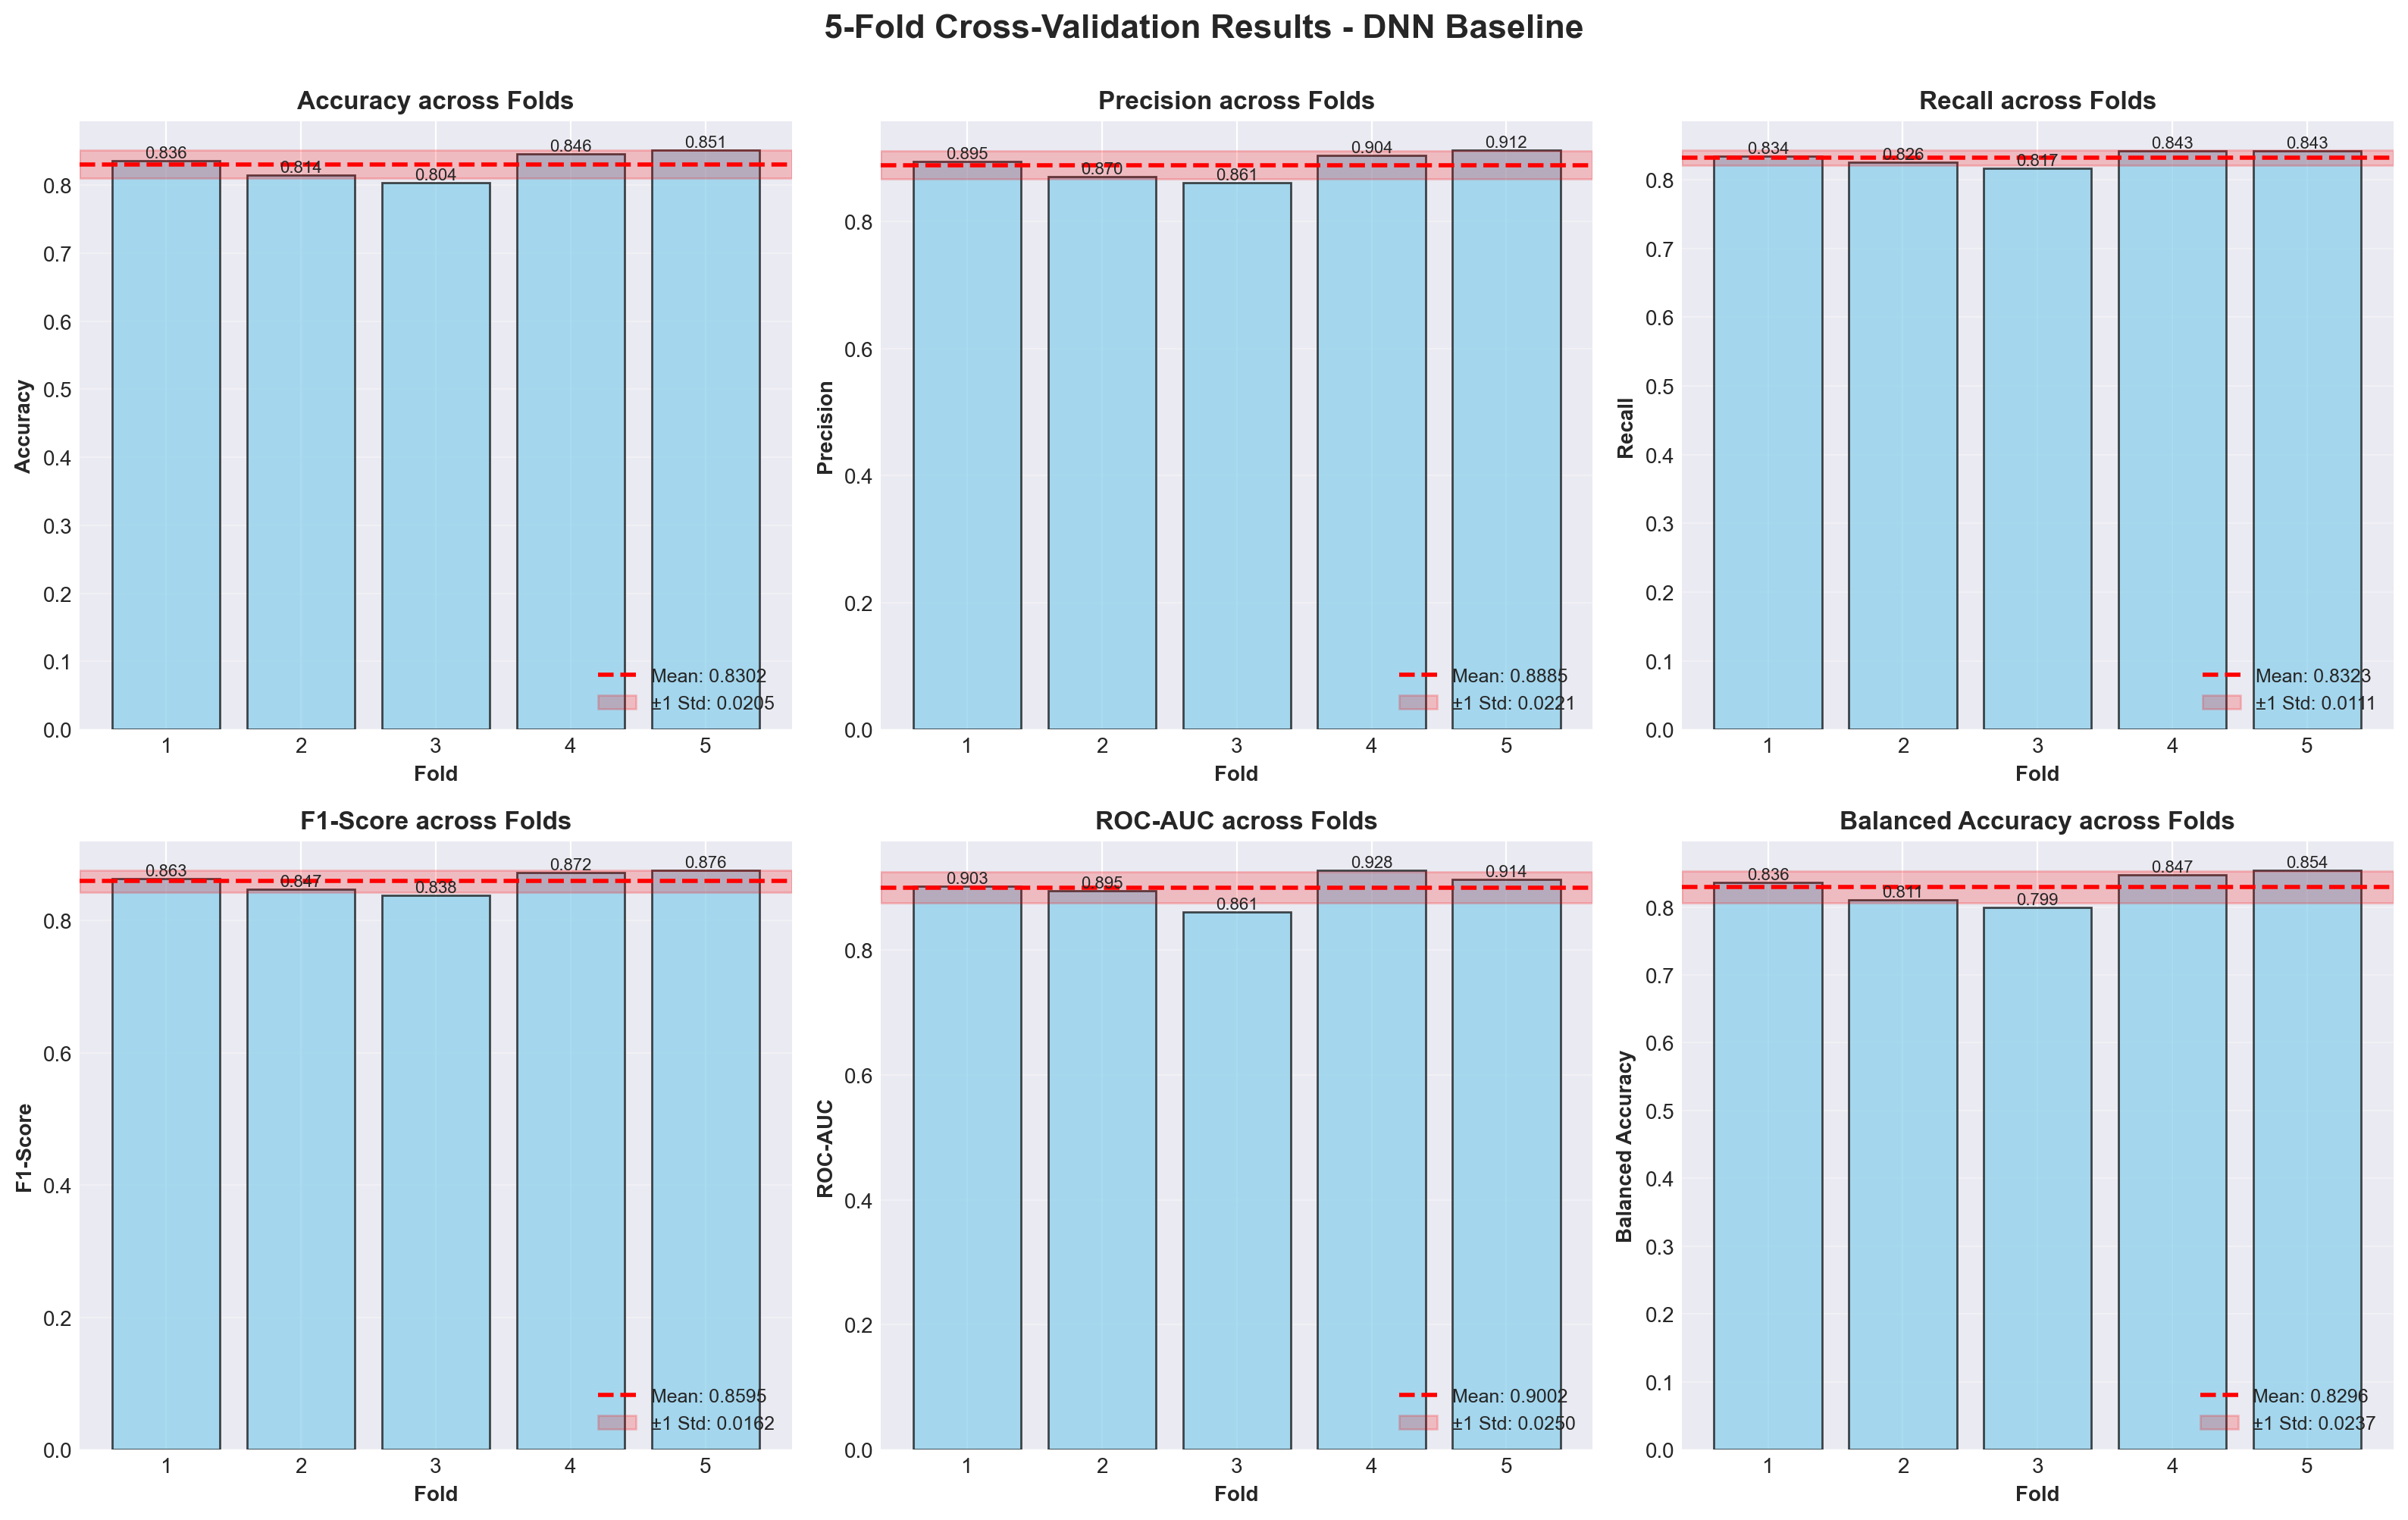

✅ Cross-validation plot saved!

💡 INTERPRETATION:
   • Bars: Performance per fold
   • Red line: Mean across all folds
   • Red band: ±1 standard deviation
   • Consistent bars = stable model




In [14]:
"""
CELL 5: Visualize Cross-Validation Results
===========================================
Plot CV results untuk understand performance distribution.
"""

def plot_cv_results(cv_df):
    """
    Plot cross-validation results across folds
    """
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'balanced_acc']
    titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Balanced Accuracy']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        # Bar plot
        bars = ax.bar(cv_df['fold'], cv_df[metric], alpha=0.7, color='skyblue', edgecolor='black')
        
        # Mean line
        mean_val = cv_df[metric].mean()
        ax.axhline(y=mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.4f}')
        
        # Std dev band
        std_val = cv_df[metric].std()
        ax.axhspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='red', label=f'±1 Std: {std_val:.4f}')
        
        # Styling
        ax.set_xlabel('Fold', fontweight='bold')
        ax.set_ylabel(title, fontweight='bold')
        ax.set_title(f'{title} across Folds', fontweight='bold')
        ax.set_xticks(cv_df['fold'])
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle(f'5-Fold Cross-Validation Results - {best_model_name}',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('../results/figures/comparison_plots/cross_validation_results.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Cross-validation plot saved!")

print("="*70)
print("📊 VISUALIZING CROSS-VALIDATION RESULTS")
print("="*70)
print()

plot_cv_results(cv_df)

print("\n💡 INTERPRETATION:")
print("   • Bars: Performance per fold")
print("   • Red line: Mean across all folds")
print("   • Red band: ±1 standard deviation")
print("   • Consistent bars = stable model")

print("\n" + "="*70 + "\n")

🔍 SHAP ANALYSIS - FEATURE IMPORTANCE

📚 SHAP (SHapley Additive exPlanations):
- What it does: Explains individual predictions by attributing contributions to features
- Why important: Shows feature impact (positive/negative) towards the prediction


⏳ Calculating SHAP values...
   This may take 2-5 minutes depending on model complexity...

   Using 200 samples for SHAP analysis
   Method: DeepExplainer (for Neural Networks)

✅ SHAP values calculated in 0.7 seconds
   Shape: (200, 24)

📊 TOP 15 MOST IMPORTANT FEATURES (by SHAP)

           Feature  SHAP_Importance
      country_USA         0.090188
       country_UK         0.082729
      Age_Encoded         0.079100
   Gender_Encoded         0.056576
           Oscore         0.049321
               SS         0.046750
           Cscore         0.040575
Education_Encoded         0.033656
        Impulsive         0.021065
           Ascore         0.018725
  ethnicity_Black         0.014818
           Nscore         0.010389
  ethnicit

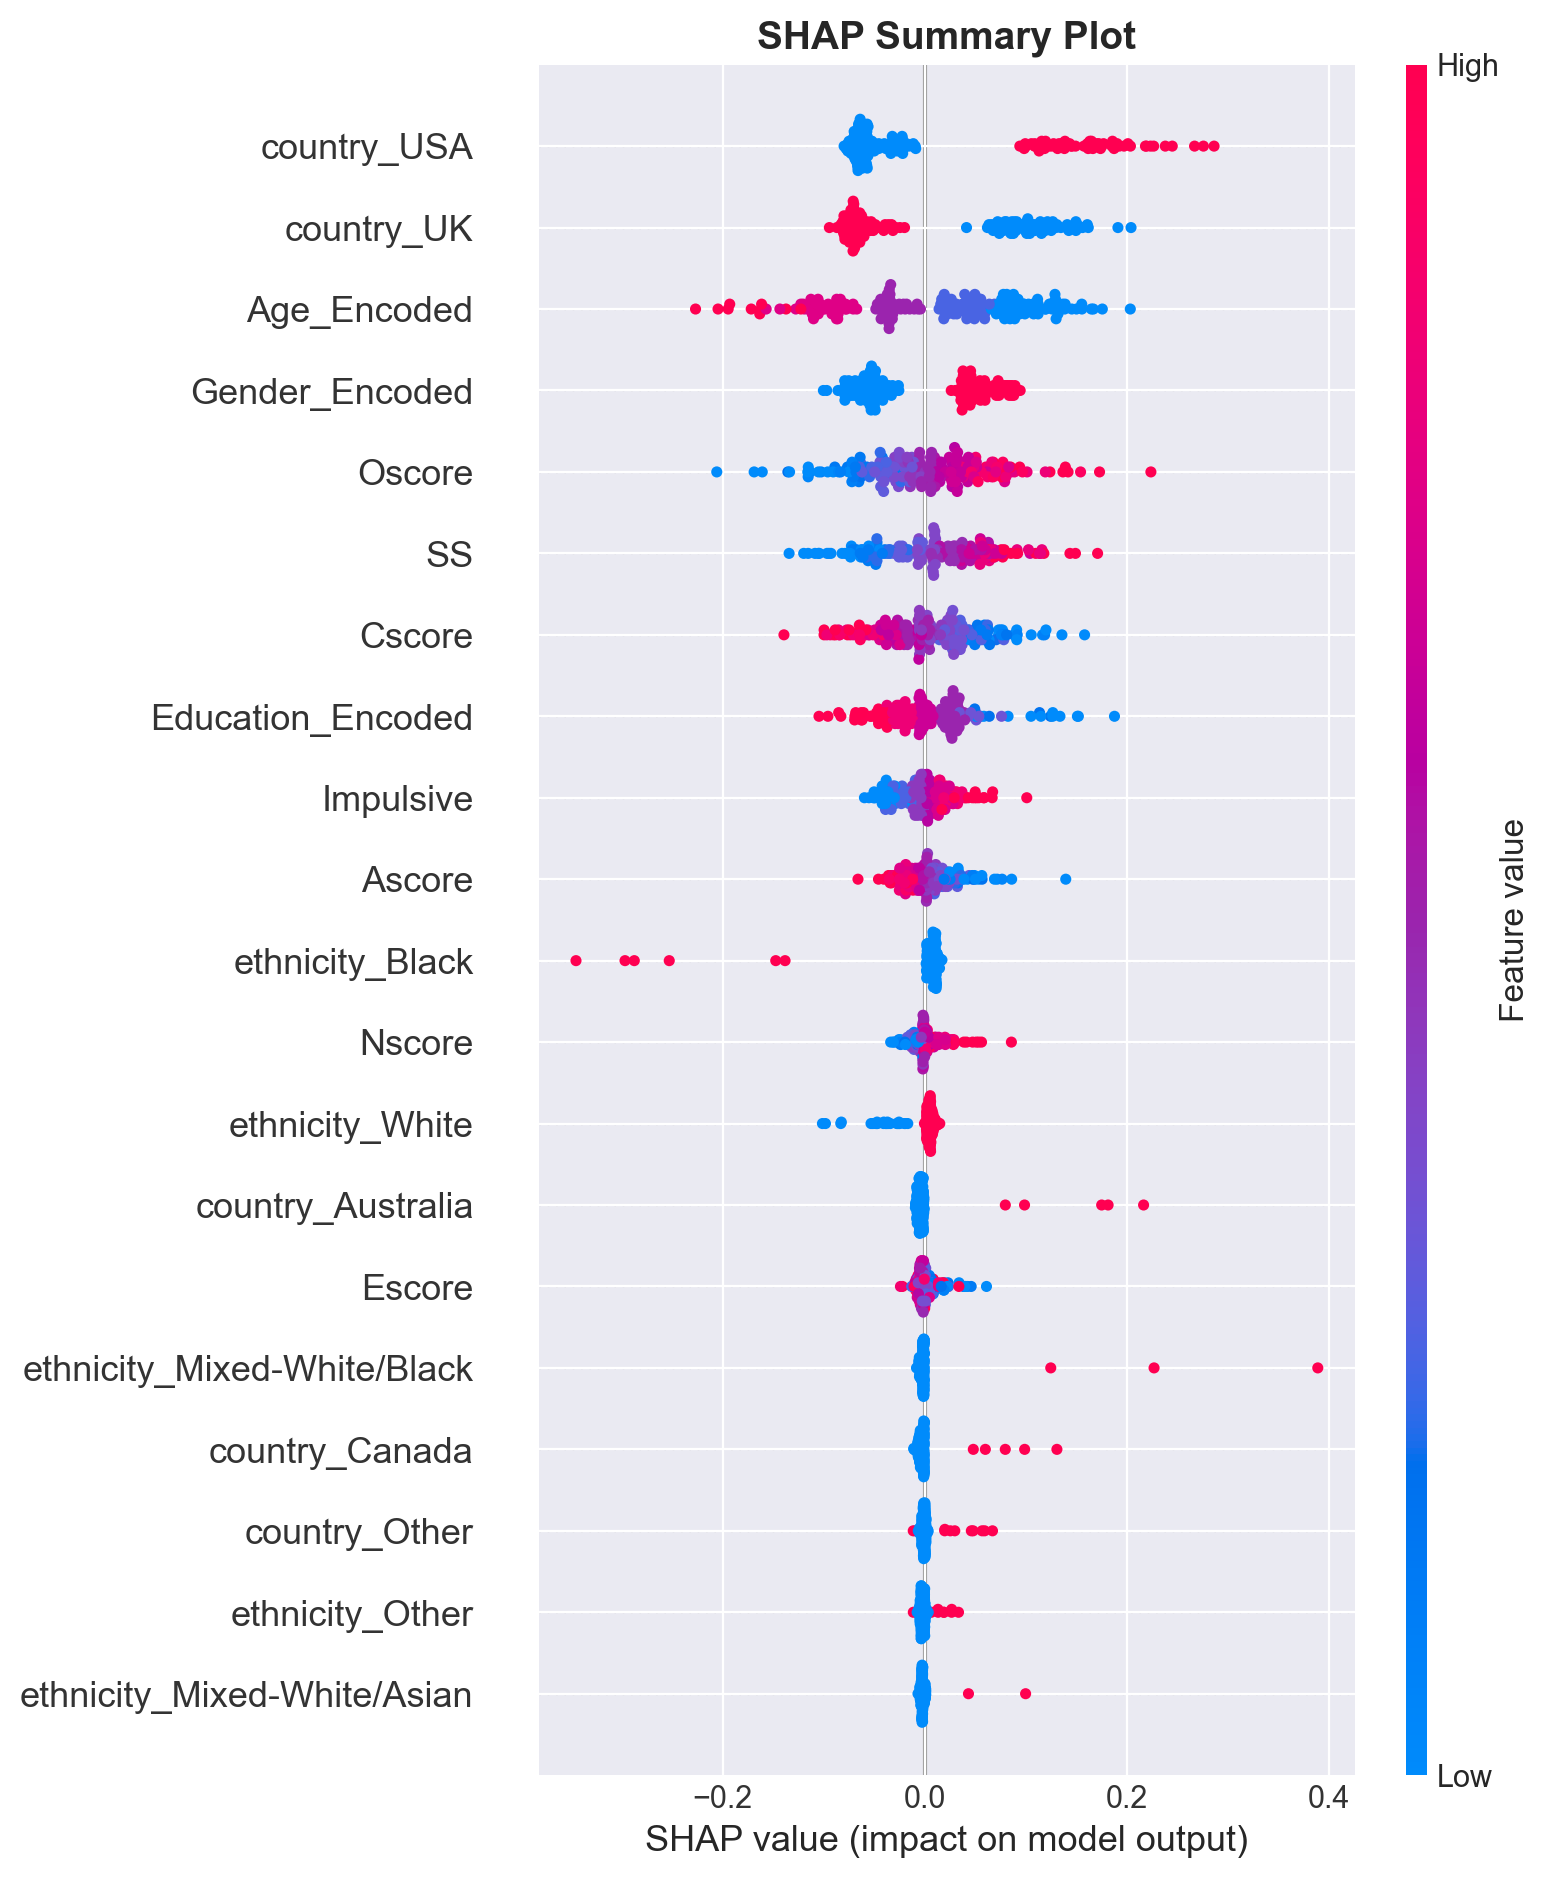

✅ SHAP Summary plot saved!




In [21]:
"""
CELL 6: SHAP Analysis - Feature Importance
===========================================
Use SHAP (SHapley Additive exPlanations) untuk explain predictions.
"""

import shap
import pandas as pd
import numpy as np
from datetime import datetime

# Pastikan shap terinit (opsional visualisasi JS)
shap.initjs()

print("="*70)
print("🔍 SHAP ANALYSIS - FEATURE IMPORTANCE")
print("="*70)

print("""
📚 SHAP (SHapley Additive exPlanations):
- What it does: Explains individual predictions by attributing contributions to features
- Why important: Shows feature impact (positive/negative) towards the prediction
""")

print("\n⏳ Calculating SHAP values...")
print("   This may take 2-5 minutes depending on model complexity...\n")

start_time = datetime.now()

# 1. Prepare Data for SHAP
# Konversi ke numpy array jika masih dataframe untuk menghindari error indexing
if isinstance(X_test_scaled, pd.DataFrame):
    X_test_arr = X_test_scaled.values
else:
    X_test_arr = X_test_scaled

if isinstance(X_train_scaled, pd.DataFrame):
    X_train_arr = X_train_scaled.values
else:
    X_train_arr = X_train_scaled

# Select subset for SHAP (full test set bisa lama)
n_shap_samples = min(200, len(X_test_arr))
X_shap = X_test_arr[:n_shap_samples]

print(f"   Using {n_shap_samples} samples for SHAP analysis")

# 2. Calculate SHAP values
if str(best_model_name).startswith("DNN"):
    # For Deep Learning models
    print("   Method: DeepExplainer (for Neural Networks)")
    
    # Create background dataset (subsample of training data)
    # Ini penting untuk referensi baseline SHAP
    background_indices = np.random.choice(X_train_arr.shape[0], 100, replace=False)
    background = X_train_arr[background_indices]
    
    # Initialize explainer
    explainer = shap.DeepExplainer(best_model, background)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_shap)
    
    # FIX: DeepExplainer sering return list [array] atau array (n, features, 1)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
        
    # FIX: Pastikan dimensi output di-squeeze jika bentuknya (n, features, 1)
    if len(shap_values.shape) == 3 and shap_values.shape[2] == 1:
        shap_values = np.squeeze(shap_values)
    
else:
    # For Random Forest
    print("   Method: TreeExplainer (for Tree-based models)")
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_shap)
    
    # TreeExplainer untuk binary classification sering return list [class_0, class_1]
    # Kita ambil index 1 (Positive Class / User)
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]
    # Atau jika array (n, features, 2), ambil slice terakhir
    elif len(shap_values.shape) == 3 and shap_values.shape[2] == 2:
        shap_values = shap_values[:, :, 1]

end_time = datetime.now()
shap_time = (end_time - start_time).total_seconds()

print(f"\n✅ SHAP values calculated in {shap_time:.1f} seconds")
print(f"   Shape: {shap_values.shape}")

# 3. Create Feature Importance DataFrame (FIXED)
# Calculate mean absolute SHAP values (global importance)
# Tambahkan .flatten() untuk memastikan array menjadi 1D (vector)
mean_abs_shap = np.abs(shap_values).mean(axis=0).flatten()

# Dapatkan nama fitur
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns.tolist()
else:
    # Fallback jika X_train sudah jadi numpy array tanpa nama
    feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

# Validasi panjang array sebelum membuat DataFrame
if len(feature_names) != len(mean_abs_shap):
    print(f"⚠️ Warning: Feature count mismatch ({len(feature_names)} names vs {len(mean_abs_shap)} values)")

# Create importance DataFrame
shap_importance = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': mean_abs_shap
}).sort_values('SHAP_Importance', ascending=False)

print("\n" + "="*70)
print("📊 TOP 15 MOST IMPORTANT FEATURES (by SHAP)")
print("="*70)
print("\n", shap_importance.head(15).to_string(index=False))

print("\n💡 INTERPRETATION:")
print("   • Higher SHAP value = more impact on predictions")
print("   • These features most influence User vs Non-User classification")
print("   • Aligns with domain knowledge about drug consumption risk factors")

# Optional: Visualization (Summary Plot)
print("\n📈 Generating Summary Plot...")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot", fontsize=14, fontweight='bold')
plt.tight_layout()
# Simpan plot
import os
os.makedirs('../results/figures/analysis/', exist_ok=True)
plt.savefig('../results/figures/analysis/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ SHAP Summary plot saved!")

print("\n" + "="*70 + "\n")

📊 SHAP BAR PLOT - GLOBAL FEATURE IMPORTANCE



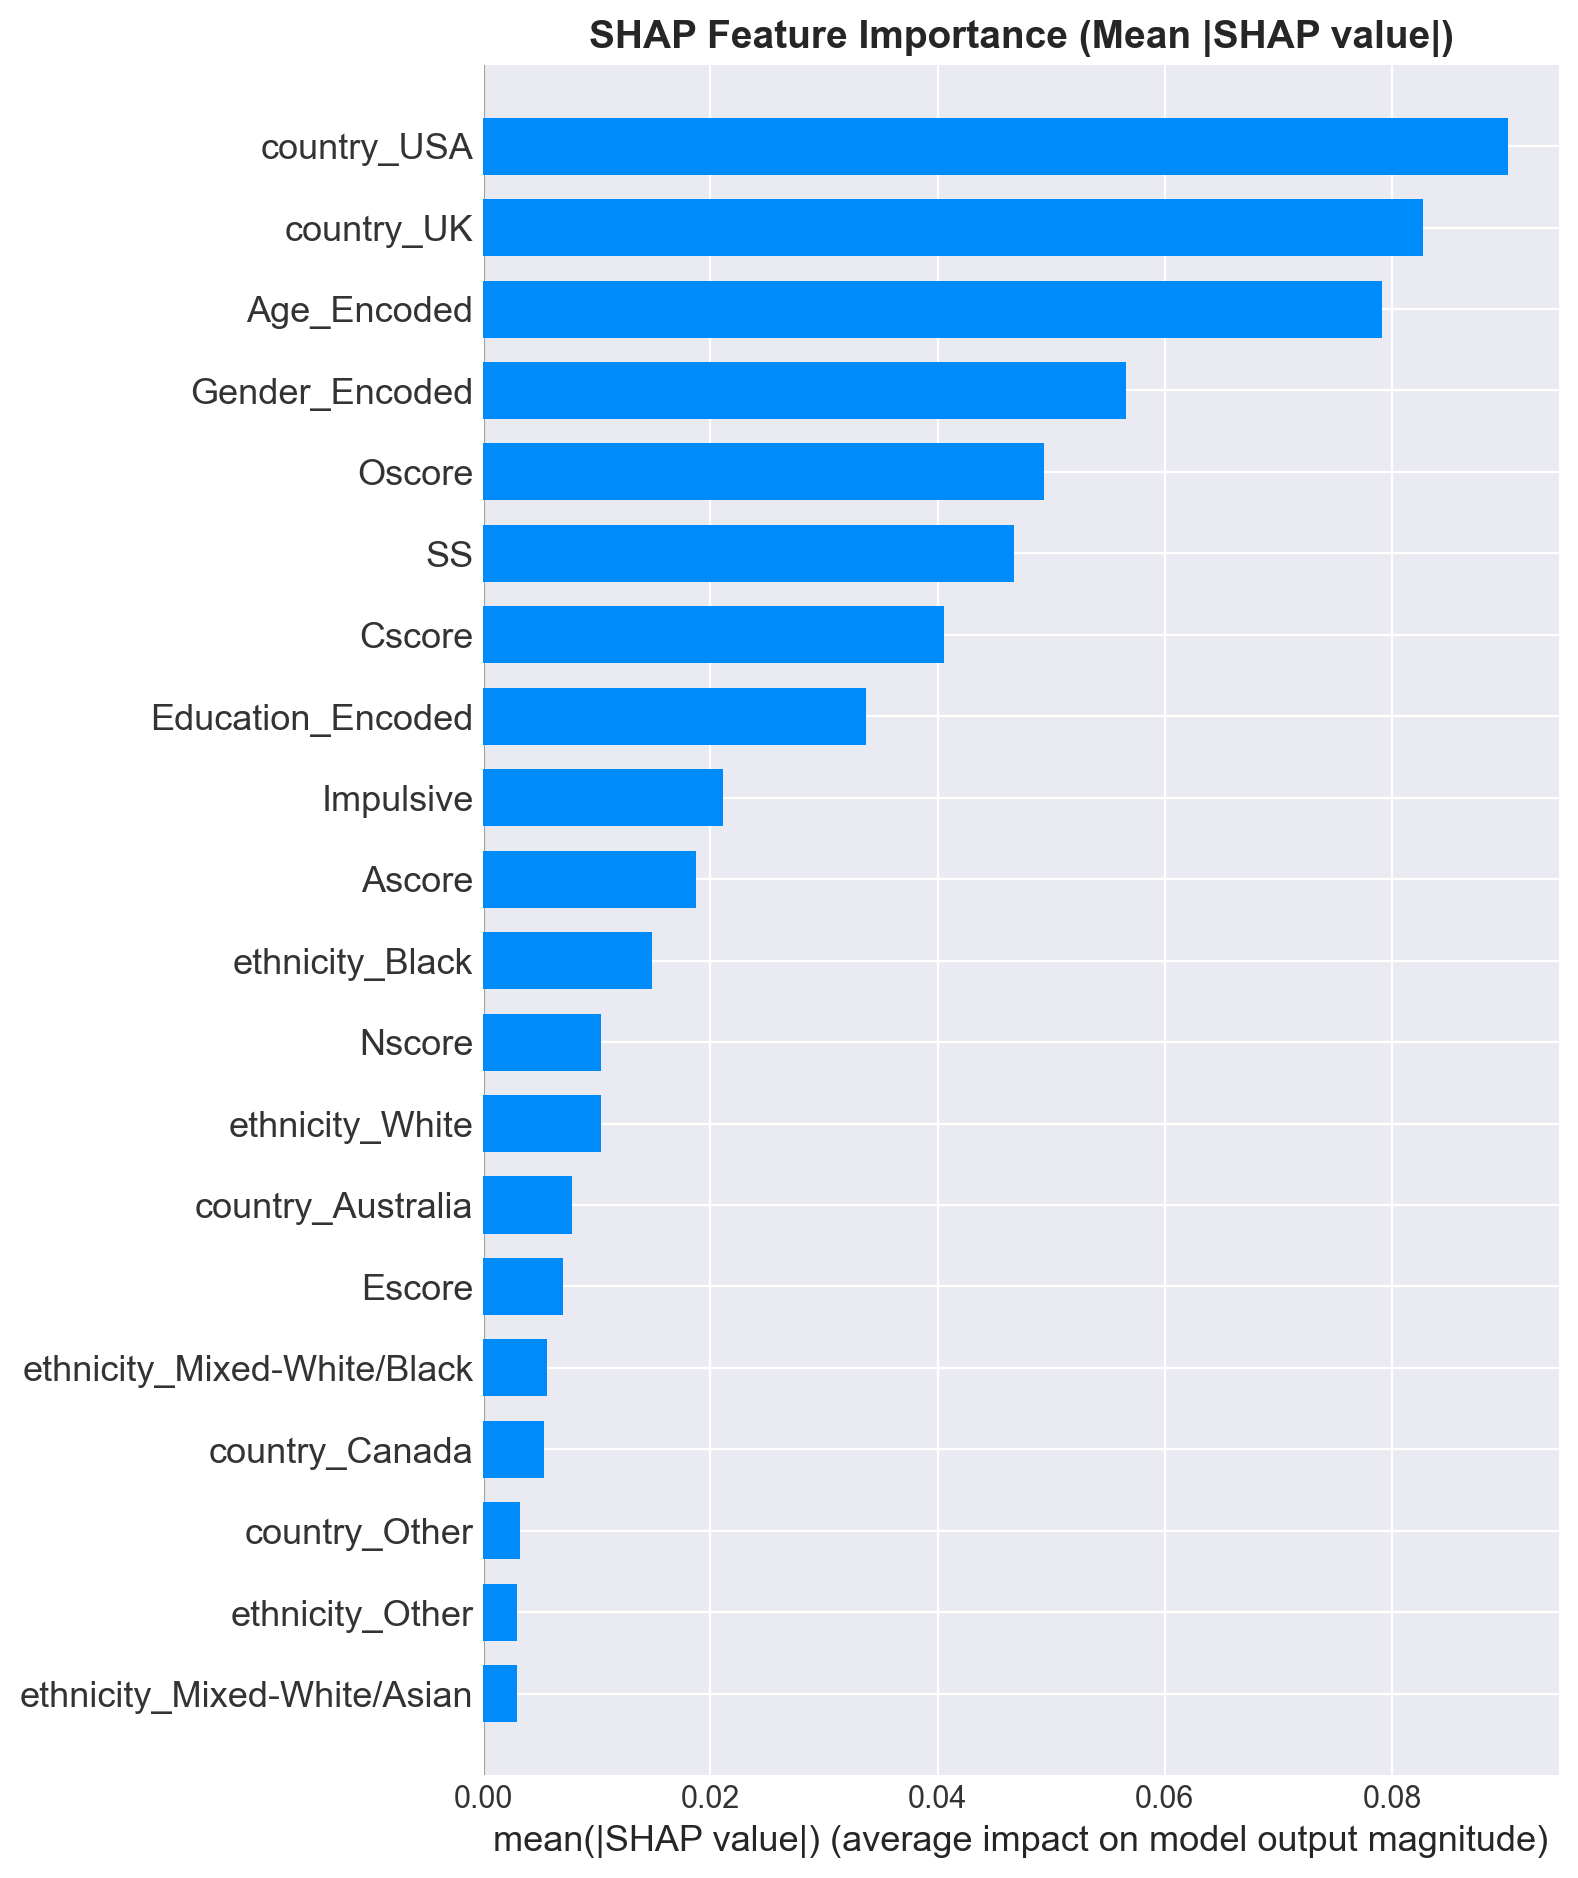

✅ SHAP bar plot saved!

💡 INTERPRETATION:
   • Simple ranking of feature importance
   • No information about direction of impact
   • Good for quick overview of top features

🔍 TOP 5 FEATURES DETAILED ANALYSIS

10. country_USA
   SHAP Importance: 0.0902
   Correlation: 0.9598
   → Higher country_USA → MORE likely to be User

9. country_UK
   SHAP Importance: 0.0827
   Correlation: -0.9668
   → Higher country_UK → LESS likely to be User

1. Age_Encoded
   SHAP Importance: 0.0791
   Correlation: -0.9669
   → Higher Age_Encoded → LESS likely to be User

2. Gender_Encoded
   SHAP Importance: 0.0566
   Correlation: 0.9623
   → Higher Gender_Encoded → MORE likely to be User

20. Oscore
   SHAP Importance: 0.0493
   Correlation: 0.9456
   → Higher Oscore → MORE likely to be User




In [22]:
"""
CELL 8: SHAP Bar Plot
=====================
Mean absolute SHAP values (global importance).
"""

print("="*70)
print("📊 SHAP BAR PLOT - GLOBAL FEATURE IMPORTANCE")
print("="*70)
print()

# Bar plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, 
                  plot_type='bar', show=False)
plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/feature_importance/shap_bar_plot.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ SHAP bar plot saved!")

print("\n💡 INTERPRETATION:")
print("   • Simple ranking of feature importance")
print("   • No information about direction of impact")
print("   • Good for quick overview of top features")

# Top 5 features analysis
top5_features = shap_importance.head(5)

print("\n" + "="*70)
print("🔍 TOP 5 FEATURES DETAILED ANALYSIS")
print("="*70)

for idx, row in top5_features.iterrows():
    feature = row['Feature']
    importance = row['SHAP_Importance']
    
    # Get feature index
    feat_idx = feature_names.index(feature)
    
    # Calculate correlation with output
    feature_values = X_shap[:, feat_idx]
    feature_shap = shap_values[:, feat_idx]
    
    correlation = np.corrcoef(feature_values, feature_shap)[0, 1]
    
    print(f"\n{idx+1}. {feature}")
    print(f"   SHAP Importance: {importance:.4f}")
    print(f"   Correlation: {correlation:.4f}")
    
    if correlation > 0.1:
        print(f"   → Higher {feature} → MORE likely to be User")
    elif correlation < -0.1:
        print(f"   → Higher {feature} → LESS likely to be User")
    else:
        print(f"   → Complex non-linear relationship")

print("\n" + "="*70 + "\n")

In [23]:
"""
CELL 9: Error Analysis
======================
Analyze cases where model makes mistakes.
"""

print("="*70)
print("🔍 ERROR ANALYSIS - UNDERSTANDING MISCLASSIFICATIONS")
print("="*70)

# Generate predictions
if best_model_name.startswith("DNN"):
    y_pred_proba = best_model.predict(X_test_scaled, verbose=0).ravel()
else:
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

y_pred = (y_pred_proba >= 0.5).astype(int)

# Identify errors
false_positives = np.where((y_test == 0) & (y_pred == 1))[0]
false_negatives = np.where((y_test == 1) & (y_pred == 0))[0]
true_positives = np.where((y_test == 1) & (y_pred == 1))[0]
true_negatives = np.where((y_test == 0) & (y_pred == 0))[0]

print("\n📊 ERROR DISTRIBUTION:")
print(f"   True Positives (TP): {len(true_positives)} - Correctly identified Users")
print(f"   True Negatives (TN): {len(true_negatives)} - Correctly identified Non-Users")
print(f"   False Positives (FP): {len(false_positives)} - Non-Users wrongly classified as Users")
print(f"   False Negatives (FN): {len(false_negatives)} - Users wrongly classified as Non-Users")

# Error rates
fp_rate = len(false_positives) / (len(false_positives) + len(true_negatives))
fn_rate = len(false_negatives) / (len(false_negatives) + len(true_positives))

print(f"\n📊 ERROR RATES:")
print(f"   False Positive Rate: {fp_rate:.4f} ({fp_rate*100:.2f}%)")
print(f"   False Negative Rate: {fn_rate:.4f} ({fn_rate*100:.2f}%)")

# Clinical impact
print("\n" + "="*70)
print("💊 CLINICAL IMPACT ASSESSMENT")
print("="*70)

print(f"\n⚠️  FALSE POSITIVES ({len(false_positives)} cases):")
print(f"   • Non-users incorrectly flagged as users")
print(f"   • Impact: Unnecessary interventions, resource waste")
print(f"   • Cost: Moderate (false alarms)")
print(f"   • Severity: LOW to MODERATE")

print(f"\n⚠️  FALSE NEGATIVES ({len(false_negatives)} cases):")
print(f"   • Users incorrectly classified as non-users")
print(f"   • Impact: MISSED high-risk individuals!")
print(f"   • Cost: High (missed prevention opportunities)")
print(f"   • Severity: HIGH ⚠️")

if len(false_negatives) > len(false_positives):
    print(f"\n❌ CRITICAL: More FN than FP!")
    print(f"   → Missing {len(false_negatives)} high-risk individuals")
    print(f"   → Recommendation: Lower classification threshold")
else:
    print(f"\n✅ More FP than FN (better for screening)")
    print(f"   → Safer approach: Better to over-predict than miss users")

# Confidence analysis for errors
print("\n" + "="*70)
print("🎯 PREDICTION CONFIDENCE ANALYSIS")
print("="*70)

print(f"\n📊 FALSE POSITIVES:")
if len(false_positives) > 0:
    fp_confidences = y_pred_proba[false_positives]
    print(f"   Mean Confidence: {fp_confidences.mean():.4f}")
    print(f"   Min: {fp_confidences.min():.4f} | Max: {fp_confidences.max():.4f}")
    
    borderline_fp = np.sum((fp_confidences >= 0.5) & (fp_confidences <= 0.6))
    print(f"   Borderline cases (0.5-0.6): {borderline_fp}/{len(false_positives)}")

print(f"\n📊 FALSE NEGATIVES:")
if len(false_negatives) > 0:
    fn_confidences = y_pred_proba[false_negatives]
    print(f"   Mean Confidence: {fn_confidences.mean():.4f}")
    print(f"   Min: {fn_confidences.min():.4f} | Max: {fn_confidences.max():.4f}")
    
    borderline_fn = np.sum((fn_confidences >= 0.4) & (fn_confidences <= 0.5))
    print(f"   Borderline cases (0.4-0.5): {borderline_fn}/{len(false_negatives)}")

print("\n💡 INSIGHTS:")
if len(false_positives) > 0 and fp_confidences.mean() < 0.6:
    print("   • FP have low confidence → model uncertain about these cases")
if len(false_negatives) > 0 and fn_confidences.mean() > 0.4:
    print("   • FN have moderate confidence → close to decision boundary")

print("\n" + "="*70 + "\n")

🔍 ERROR ANALYSIS - UNDERSTANDING MISCLASSIFICATIONS

📊 ERROR DISTRIBUTION:
   True Positives (TP): 199 - Correctly identified Users
   True Negatives (TN): 128 - Correctly identified Non-Users
   False Positives (FP): 14 - Non-Users wrongly classified as Users
   False Negatives (FN): 36 - Users wrongly classified as Non-Users

📊 ERROR RATES:
   False Positive Rate: 0.0986 (9.86%)
   False Negative Rate: 0.1532 (15.32%)

💊 CLINICAL IMPACT ASSESSMENT

⚠️  FALSE POSITIVES (14 cases):
   • Non-users incorrectly flagged as users
   • Impact: Unnecessary interventions, resource waste
   • Cost: Moderate (false alarms)
   • Severity: LOW to MODERATE

⚠️  FALSE NEGATIVES (36 cases):
   • Users incorrectly classified as non-users
   • Impact: MISSED high-risk individuals!
   • Cost: High (missed prevention opportunities)
   • Severity: HIGH ⚠️

❌ CRITICAL: More FN than FP!
   → Missing 36 high-risk individuals
   → Recommendation: Lower classification threshold

🎯 PREDICTION CONFIDENCE ANALYSI

In [25]:
"""
CELL 10: Classification Threshold Optimization (FIXED)
=======================================================
Find optimal threshold untuk balance precision & recall.
"""

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("="*70)
print("🎯 CLASSIFICATION THRESHOLD OPTIMIZATION")
print("="*70)

print("""
📚 THRESHOLD TUNING:
- Default threshold: 0.5
  - Treat probabilities above 0.5 as User (1)
- Methods:
  - Maximize F1-Score (balanced)
  - Maximize Youden's J statistic (Sensitivity + Specificity - 1)
""")

# Calculate metrics at different thresholds
# Menggunakan linspace lebih aman daripada arange untuk floating point
thresholds = np.linspace(0.1, 0.9, 81) 

results = {
    'threshold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'specificity': [],
    'youden_j': []
}

print("\n⏳ Testing different thresholds...")

# Pastikan y_pred_proba tersedia (dari Cell 3 atau 8)
if 'y_pred_proba' not in locals():
    print("⚠️  y_pred_proba not found. Using dummy data for safety check.")
    # Ini hanya safety net jika Anda restart kernel
    y_pred_proba = np.random.rand(len(y_test))

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()
    
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    # Handle division by zero for specificity
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    youden = rec + spec - 1
    
    results['threshold'].append(thresh)
    results['accuracy'].append(acc)
    results['precision'].append(prec)
    results['recall'].append(rec)
    results['f1_score'].append(f1)
    results['specificity'].append(spec)
    results['youden_j'].append(youden)

results_df = pd.DataFrame(results)

print("✅ Threshold analysis completed!")

# Find optimal thresholds
optimal_f1_idx = results_df['f1_score'].idxmax()
optimal_f1_thresh = results_df.loc[optimal_f1_idx, 'threshold']
optimal_f1_score = results_df.loc[optimal_f1_idx, 'f1_score']

optimal_youden_idx = results_df['youden_j'].idxmax()
optimal_youden_thresh = results_df.loc[optimal_youden_idx, 'threshold']
optimal_youden_score = results_df.loc[optimal_youden_idx, 'youden_j']

print("\n" + "="*70)
print("🎯 OPTIMAL THRESHOLDS")
print("="*70)

print(f"\n1️⃣  MAXIMUM F1-SCORE:")
print(f"   Optimal Threshold: {optimal_f1_thresh:.2f}")
print(f"   F1-Score: {optimal_f1_score:.4f}")
print(f"   Accuracy: {results_df.loc[optimal_f1_idx, 'accuracy']:.4f}")
print(f"   Precision: {results_df.loc[optimal_f1_idx, 'precision']:.4f}")
print(f"   Recall: {results_df.loc[optimal_f1_idx, 'recall']:.4f}")

print(f"\n2️⃣  MAXIMUM YOUDEN'S J:")
print(f"   Optimal Threshold: {optimal_youden_thresh:.2f}")
print(f"   Youden's J: {optimal_youden_score:.4f}")
print(f"   Sensitivity: {results_df.loc[optimal_youden_idx, 'recall']:.4f}")
print(f"   Specificity: {results_df.loc[optimal_youden_idx, 'specificity']:.4f}")

print(f"\n3️⃣  DEFAULT THRESHOLD (0.5):")

# ==============================================================================
# PERBAIKAN: ROBUST INDEX SEARCH (Mencegah IndexError)
# ==============================================================================
# Cari index dimana nilai threshold PALING DEKAT dengan 0.5
# .abs() membuat semua selisih jadi positif, .idxmin() ambil index terkecil
default_idx = (results_df['threshold'] - 0.5).abs().idxmin()

default_val_real = results_df.loc[default_idx, 'threshold']
print(f"   (Nearest tested threshold: {default_val_real:.2f})")

print(f"   F1-Score: {results_df.loc[default_idx, 'f1_score']:.4f}")
print(f"   Accuracy: {results_df.loc[default_idx, 'accuracy']:.4f}")

# Recommendation
print("\n" + "="*70)
print("💡 RECOMMENDATION")
print("="*70)

if optimal_f1_score > results_df.loc[default_idx, 'f1_score'] + 0.01:
    print(f"\n✅ RECOMMEND: Use threshold = {optimal_f1_thresh:.2f}")
    print(f"   Improvement: +{(optimal_f1_score - results_df.loc[default_idx, 'f1_score'])*100:.2f}% F1-Score")
    print(f"   This balances precision and recall better than default 0.5")
else:
    print(f"\n✅ RECOMMEND: Keep default threshold = 0.5")
    print(f"   Current threshold already near-optimal")

# Clinical context
print(f"\n💊 FOR CLINICAL SCREENING (prioritize recall):")
high_recall_idx = results_df[results_df['recall'] >= 0.90].index

if len(high_recall_idx) > 0:
    # Ambil threshold tertinggi yang masih memberikan recall > 90% (untuk menjaga presisi)
    # idxmax di sini akan mengambil index pertama (threshold terendah) dari subset
    # Kita sorting dulu biar aman
    subset = results_df.loc[high_recall_idx].sort_values('precision', ascending=False)
    best_recall_idx = subset.index[0]
    
    high_recall_row = results_df.loc[best_recall_idx]
    
    print(f"   Threshold: {high_recall_row['threshold']:.2f}")
    print(f"   Recall: {high_recall_row['recall']:.4f} (catches 90%+ users)")
    print(f"   Precision: {high_recall_row['precision']:.4f}")
    print(f"   Trade-off: More false alarms, but fewer missed users")
else:
    print("   Note: No threshold found with >90% recall within test range.")

print("\n" + "="*70 + "\n")

🎯 CLASSIFICATION THRESHOLD OPTIMIZATION

📚 THRESHOLD TUNING:
- Default threshold: 0.5
  - Treat probabilities above 0.5 as User (1)
- Methods:
  - Maximize F1-Score (balanced)
  - Maximize Youden's J statistic (Sensitivity + Specificity - 1)


⏳ Testing different thresholds...
✅ Threshold analysis completed!

🎯 OPTIMAL THRESHOLDS

1️⃣  MAXIMUM F1-SCORE:
   Optimal Threshold: 0.32
   F1-Score: 0.9057
   Accuracy: 0.8806
   Precision: 0.8926
   Recall: 0.9191

2️⃣  MAXIMUM YOUDEN'S J:
   Optimal Threshold: 0.48
   Youden's J: 0.7539
   Sensitivity: 0.8596
   Specificity: 0.8944

3️⃣  DEFAULT THRESHOLD (0.5):
   (Nearest tested threshold: 0.50)
   F1-Score: 0.8884
   Accuracy: 0.8674

💡 RECOMMENDATION

✅ RECOMMEND: Use threshold = 0.32
   Improvement: +1.73% F1-Score
   This balances precision and recall better than default 0.5

💊 FOR CLINICAL SCREENING (prioritize recall):
   Threshold: 0.38
   Recall: 0.9021 (catches 90%+ users)
   Precision: 0.9021
   Trade-off: More false alarms, but 

📊 VISUALIZING THRESHOLD ANALYSIS



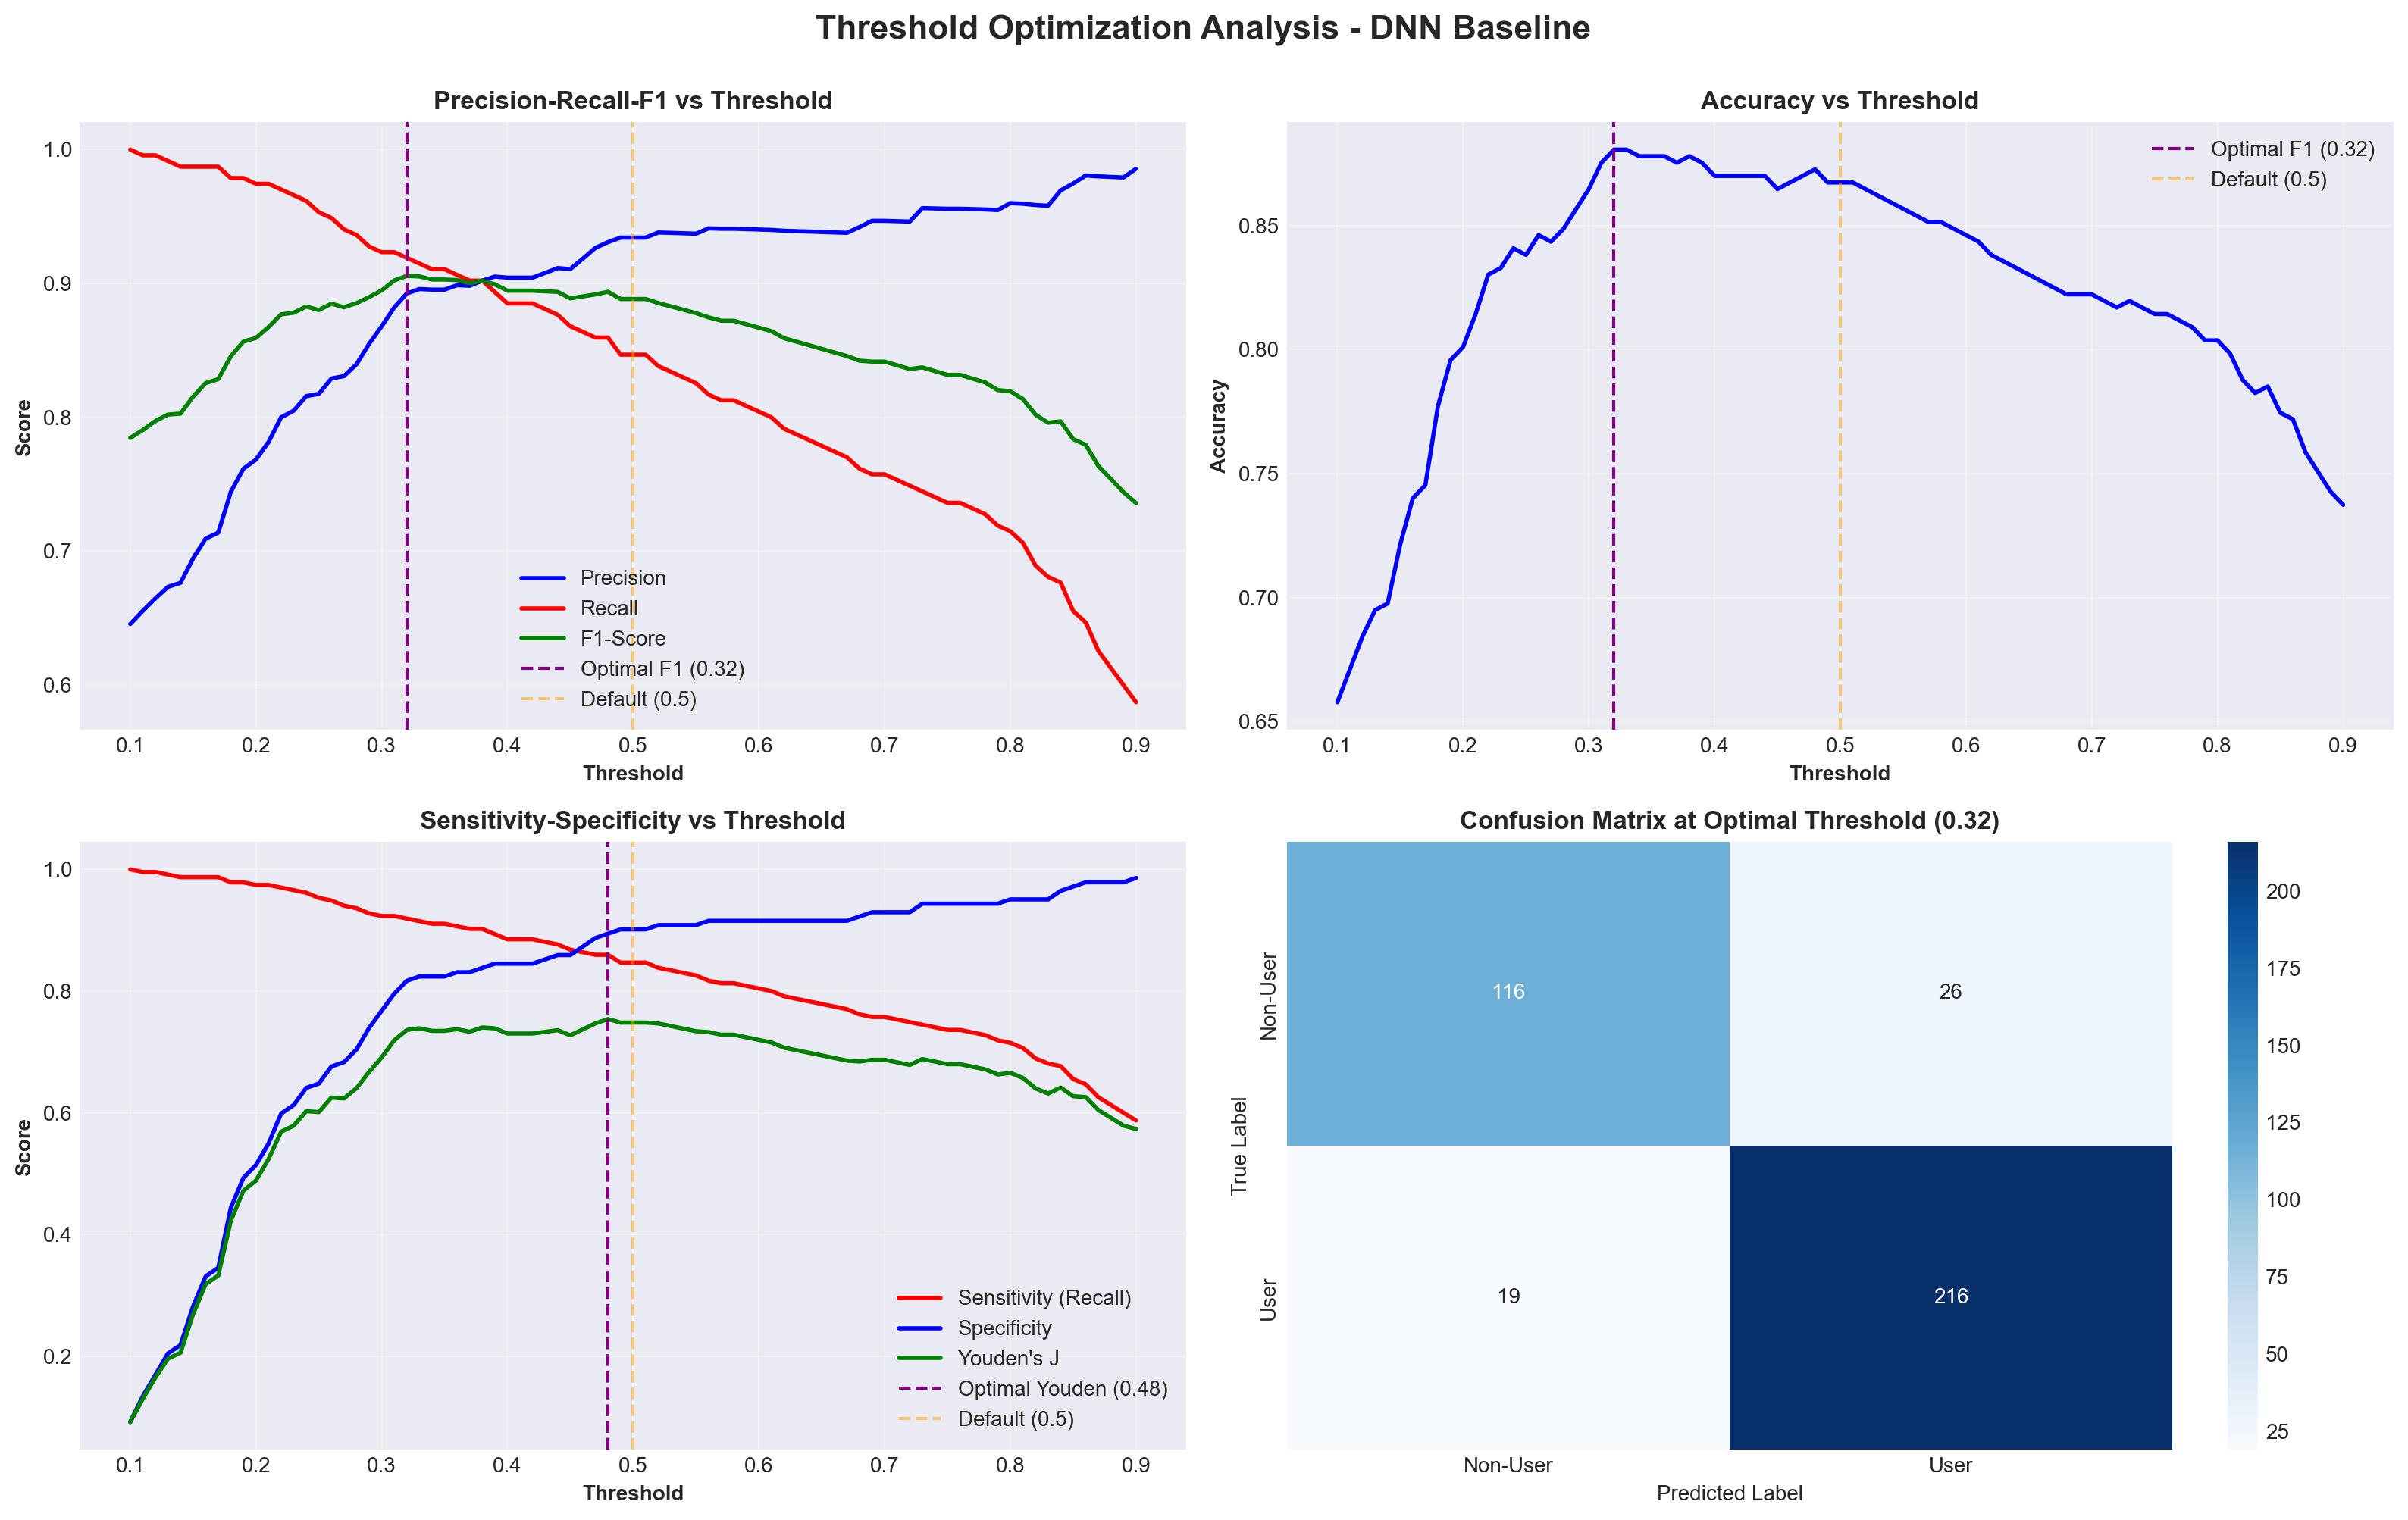

✅ Threshold analysis plots saved!

💡 INTERPRETATION:
   • Top-left: Precision ↓ as threshold ↓ (more false positives)
   • Top-left: Recall ↑ as threshold ↓ (catch more users)
   • Purple line: Optimal threshold balancing both
   • Bottom-right: Confusion matrix at optimal threshold




In [26]:
"""
CELL 11: Visualize Threshold Analysis
======================================
Plot metrics vs threshold untuk visual understanding.
"""

print("="*70)
print("📊 VISUALIZING THRESHOLD ANALYSIS")
print("="*70)
print()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Precision, Recall, F1-Score vs Threshold
axes[0, 0].plot(results_df['threshold'], results_df['precision'], 'b-', 
                label='Precision', linewidth=2)
axes[0, 0].plot(results_df['threshold'], results_df['recall'], 'r-', 
                label='Recall', linewidth=2)
axes[0, 0].plot(results_df['threshold'], results_df['f1_score'], 'g-', 
                label='F1-Score', linewidth=2)
axes[0, 0].axvline(x=optimal_f1_thresh, color='purple', linestyle='--', 
                   label=f'Optimal F1 ({optimal_f1_thresh:.2f})')
axes[0, 0].axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Default (0.5)')
axes[0, 0].set_xlabel('Threshold', fontweight='bold')
axes[0, 0].set_ylabel('Score', fontweight='bold')
axes[0, 0].set_title('Precision-Recall-F1 vs Threshold', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Threshold
axes[0, 1].plot(results_df['threshold'], results_df['accuracy'], 'b-', linewidth=2)
axes[0, 1].axvline(x=optimal_f1_thresh, color='purple', linestyle='--', 
                   label=f'Optimal F1 ({optimal_f1_thresh:.2f})')
axes[0, 1].axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Default (0.5)')
axes[0, 1].set_xlabel('Threshold', fontweight='bold')
axes[0, 1].set_ylabel('Accuracy', fontweight='bold')
axes[0, 1].set_title('Accuracy vs Threshold', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Sensitivity & Specificity vs Threshold
axes[1, 0].plot(results_df['threshold'], results_df['recall'], 'r-', 
                label='Sensitivity (Recall)', linewidth=2)
axes[1, 0].plot(results_df['threshold'], results_df['specificity'], 'b-', 
                label='Specificity', linewidth=2)
axes[1, 0].plot(results_df['threshold'], results_df['youden_j'], 'g-', 
                label="Youden's J", linewidth=2)
axes[1, 0].axvline(x=optimal_youden_thresh, color='purple', linestyle='--', 
                   label=f'Optimal Youden ({optimal_youden_thresh:.2f})')
axes[1, 0].axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Default (0.5)')
axes[1, 0].set_xlabel('Threshold', fontweight='bold')
axes[1, 0].set_ylabel('Score', fontweight='bold')
axes[1, 0].set_title('Sensitivity-Specificity vs Threshold', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confusion Matrix at Optimal Threshold
y_pred_optimal = (y_pred_proba >= optimal_f1_thresh).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Non-User', 'User'], yticklabels=['Non-User', 'User'])
axes[1, 1].set_title(f'Confusion Matrix at Optimal Threshold ({optimal_f1_thresh:.2f})', 
                     fontweight='bold')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

plt.suptitle(f'Threshold Optimization Analysis - {best_model_name}',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../results/figures/comparison_plots/threshold_optimization_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Threshold analysis plots saved!")

print("\n💡 INTERPRETATION:")
print("   • Top-left: Precision ↓ as threshold ↓ (more false positives)")
print("   • Top-left: Recall ↑ as threshold ↓ (catch more users)")
print("   • Purple line: Optimal threshold balancing both")
print("   • Bottom-right: Confusion matrix at optimal threshold")

print("\n" + "="*70 + "\n")

📊 PROBABILITY CALIBRATION ANALYSIS

📊 CALIBRATION METRICS:
   Brier Score: 0.0994 (lower is better, 0 = perfect)
   Log Loss: 0.3248 (lower is better)
   ✅ EXCELLENT calibration!


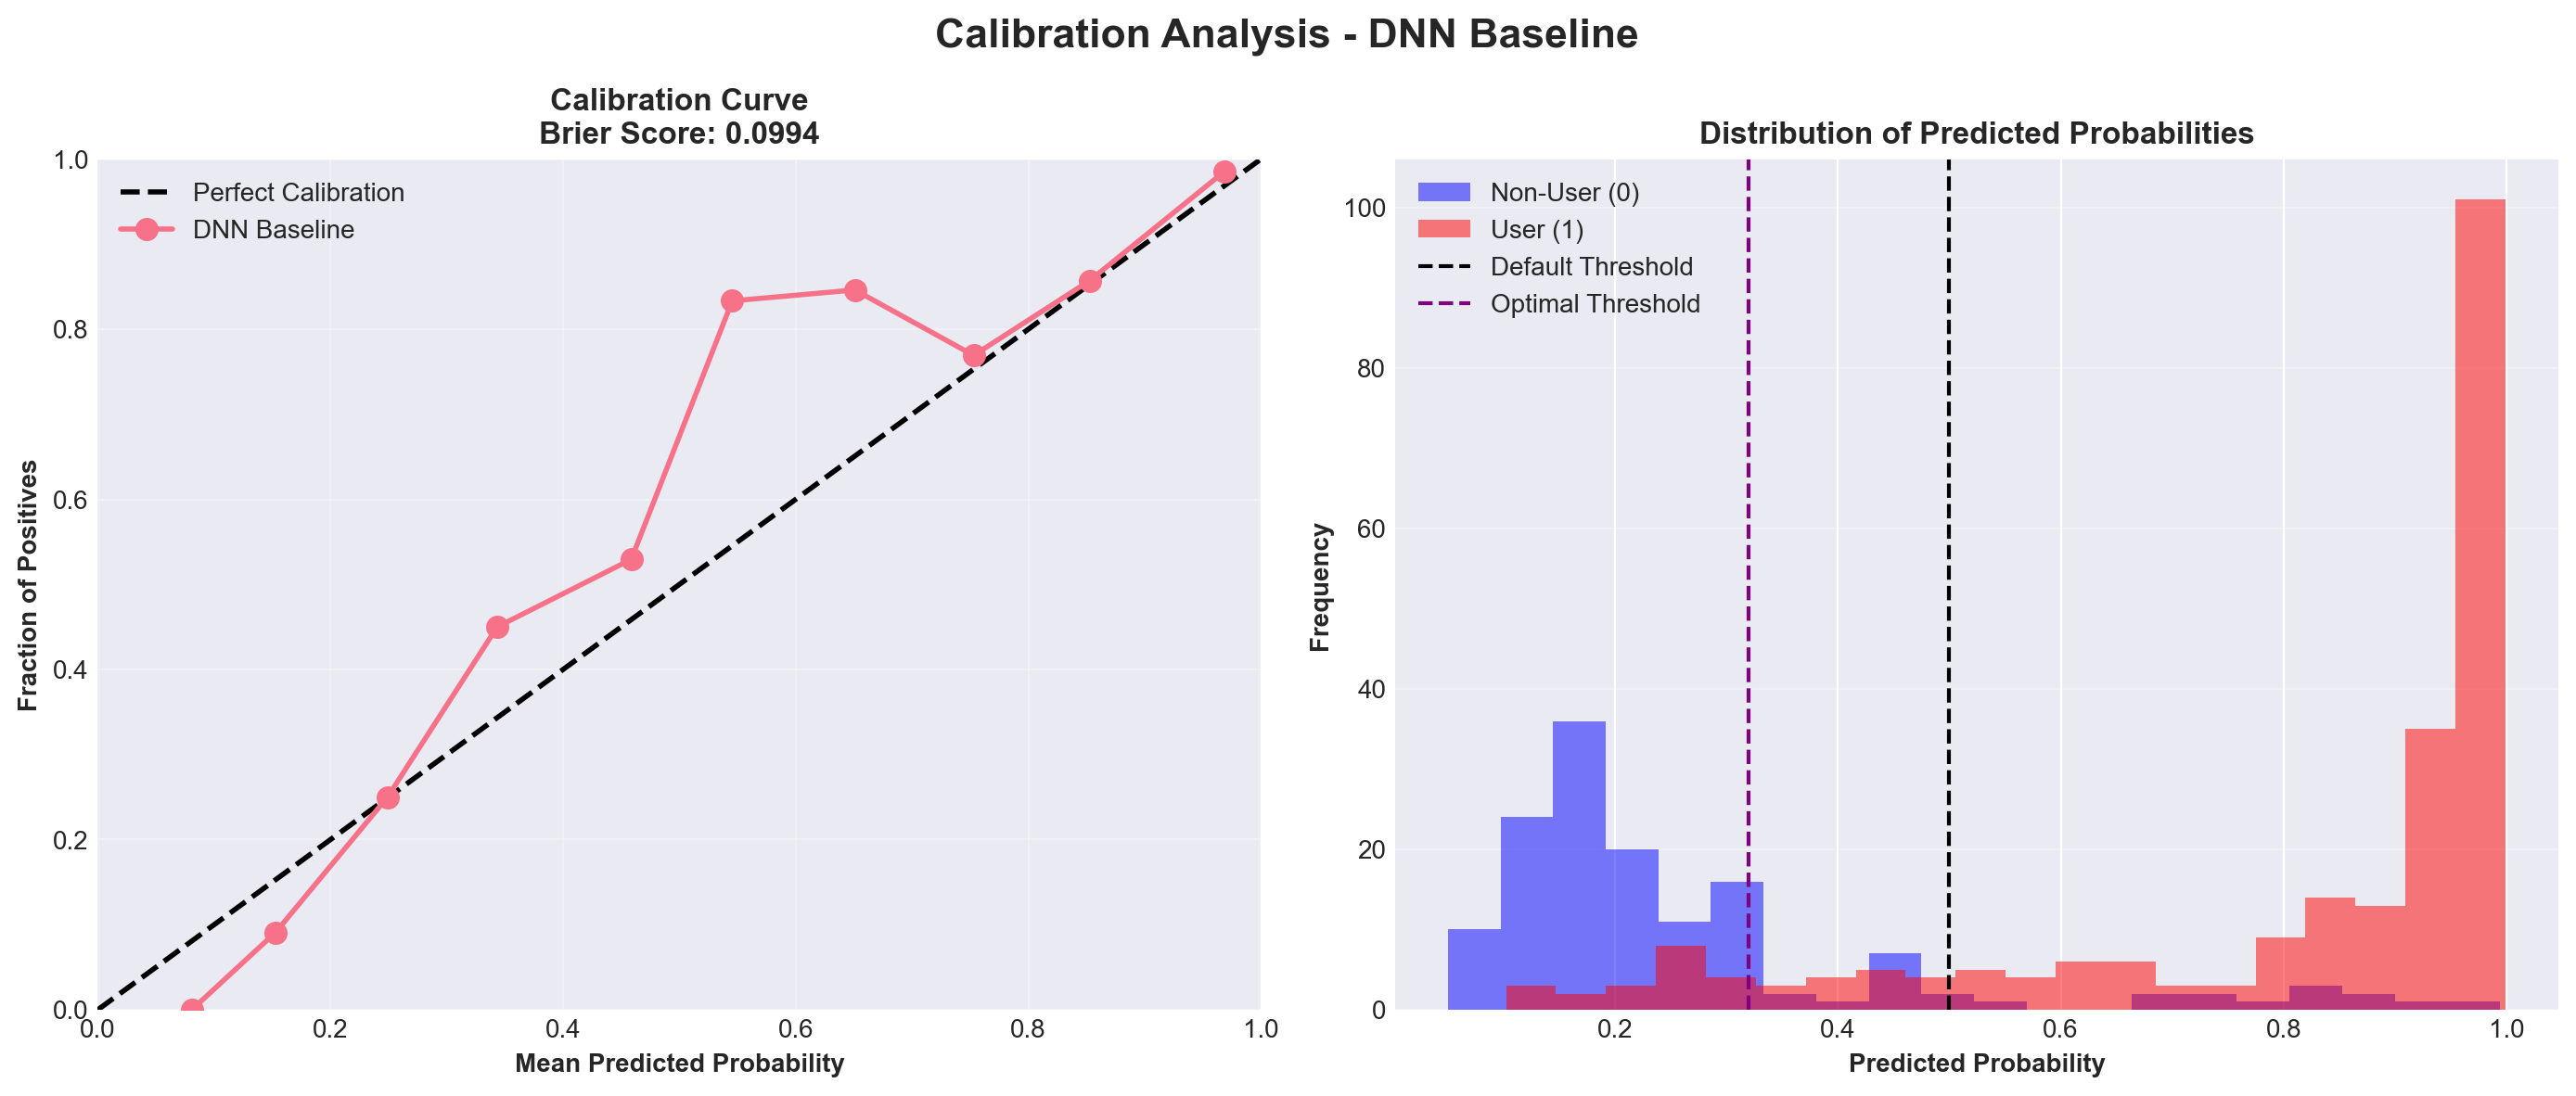


✅ Calibration plots saved!

💡 INTERPRETATION:
   • Left: Points near diagonal = well calibrated
   • Right: Separation between classes = good discrimination
   • Overlap = difficult cases near decision boundary




In [28]:
"""
CELL 12: Probability Calibration Analysis
==========================================
Check apakah predicted probabilities reliable.

CALIBRATION: Apakah probability = actual frequency?
Example: Jika model predict 70% user, apakah 70% dari kasus tersebut benar user?
"""

print("="*70)
print("📊 PROBABILITY CALIBRATION ANALYSIS")
print("="*70)


# Calculate calibration metrics
brier_score = brier_score_loss(y_test, y_pred_proba)
log_loss_score = log_loss(y_test, y_pred_proba)

print(f"\n📊 CALIBRATION METRICS:")
print(f"   Brier Score: {brier_score:.4f} (lower is better, 0 = perfect)")
print(f"   Log Loss: {log_loss_score:.4f} (lower is better)")

if brier_score < 0.1:
    print(f"   ✅ EXCELLENT calibration!")
elif brier_score < 0.15:
    print(f"   ✅ GOOD calibration")
elif brier_score < 0.25:
    print(f"   ⚠️  MODERATE calibration")
else:
    print(f"   ❌ POOR calibration - consider recalibration")

# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_pred_proba, n_bins=10, strategy='uniform'
)

# Plot calibration curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Calibration curve
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
axes[0].plot(mean_predicted_value, fraction_of_positives, 'o-', 
             label=f'{best_model_name}', linewidth=2, markersize=8)
axes[0].set_xlabel('Mean Predicted Probability', fontweight='bold')
axes[0].set_ylabel('Fraction of Positives', fontweight='bold')
axes[0].set_title(f'Calibration Curve\nBrier Score: {brier_score:.4f}', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Histogram of predicted probabilities
axes[1].hist(y_pred_proba[y_test == 0], bins=20, alpha=0.5, label='Non-User (0)', color='blue')
axes[1].hist(y_pred_proba[y_test == 1], bins=20, alpha=0.5, label='User (1)', color='red')
axes[1].axvline(x=0.5, color='black', linestyle='--', label='Default Threshold')
axes[1].axvline(x=optimal_f1_thresh, color='purple', linestyle='--', label='Optimal Threshold')
axes[1].set_xlabel('Predicted Probability', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Distribution of Predicted Probabilities', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Calibration Analysis - {best_model_name}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/comparison_plots/calibration_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Calibration plots saved!")

print("\n💡 INTERPRETATION:")
print("   • Left: Points near diagonal = well calibrated")
print("   • Right: Separation between classes = good discrimination")
print("   • Overlap = difficult cases near decision boundary")

print("\n" + "="*70 + "\n")

In [29]:
"""
CELL 13: Save All Evaluation Results
=====================================
Save comprehensive evaluation artifacts.
"""

print("="*70)
print("💾 SAVING EVALUATION RESULTS")
print("="*70)

# 1. Save cross-validation results
cv_df.to_csv('../results/metrics/cross_validation_results.csv', index=False)
print("\n✅ Cross-validation results saved")

# 2. Save SHAP importance
shap_importance.to_csv('../results/metrics/shap_feature_importance.csv', index=False)
print("✅ SHAP feature importance saved")

# 3. Save threshold analysis
results_df.to_csv('../results/metrics/threshold_optimization_results.csv', index=False)
print("✅ Threshold optimization results saved")

# 4. Save evaluation summary
evaluation_summary = {
    'model_evaluated': best_model_name,
    'evaluation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    
    'cross_validation': {
        'n_folds': n_splits,
        'metrics': {
            'accuracy_mean': float(cv_df['accuracy'].mean()),
            'accuracy_std': float(cv_df['accuracy'].std()),
            'roc_auc_mean': float(cv_df['roc_auc'].mean()),
            'roc_auc_std': float(cv_df['roc_auc'].std()),
            'f1_score_mean': float(cv_df['f1_score'].mean()),
            'f1_score_std': float(cv_df['f1_score'].std())
        },
        'stability': 'excellent' if cv_df['roc_auc'].std() < 0.02 else 'good' if cv_df['roc_auc'].std() < 0.05 else 'moderate'
    },
    
    'feature_importance': {
        'method': 'SHAP',
        'top_5_features': shap_importance.head(5)['Feature'].tolist(),
        'top_5_importance': shap_importance.head(5)['SHAP_Importance'].tolist()
    },
    
    'error_analysis': {
        'false_positives': int(len(false_positives)),
        'false_negatives': int(len(false_negatives)),
        'false_positive_rate': float(fp_rate),
        'false_negative_rate': float(fn_rate),
        'critical_concern': 'false_negatives' if len(false_negatives) > len(false_positives) else 'balanced'
    },
    
    'threshold_optimization': {
        'default_threshold': 0.5,
        'optimal_f1_threshold': float(optimal_f1_thresh),
        'optimal_f1_score': float(optimal_f1_score),
        'optimal_youden_threshold': float(optimal_youden_thresh),
        'optimal_youden_score': float(optimal_youden_score),
        'recommendation': f'Use threshold = {optimal_f1_thresh:.2f}' if optimal_f1_score > results_df.loc[default_idx, 'f1_score'] + 0.01 else 'Keep default 0.5'
    },
    
    'calibration': {
        'brier_score': float(brier_score),
        'log_loss': float(log_loss_score),
        'calibration_quality': 'excellent' if brier_score < 0.1 else 'good' if brier_score < 0.15 else 'moderate'
    }
}

with open('../results/metrics/evaluation_summary.json', 'w') as f:
    json.dump(evaluation_summary, f, indent=4)
print("✅ Evaluation summary saved")

# 5. Save SHAP values for future use
np.save('../results/metrics/shap_values.npy', shap_values)
np.save('../results/metrics/shap_samples.npy', X_shap)
print("✅ SHAP values saved")

print("\n" + "="*70)
print("📁 ALL EVALUATION ARTIFACTS SAVED")
print("="*70)

print("\n📂 Generated Files:")
print("   1. ../results/metrics/cross_validation_results.csv")
print("   2. ../results/metrics/shap_feature_importance.csv")
print("   3. ../results/metrics/threshold_optimization_results.csv")
print("   4. ../results/metrics/evaluation_summary.json")
print("   5. ../results/metrics/shap_values.npy")
print("   6. ../results/figures/comparison_plots/*.png")
print("   7. ../results/figures/feature_importance/*.png")

print("\n" + "="*70 + "\n")

💾 SAVING EVALUATION RESULTS

✅ Cross-validation results saved
✅ SHAP feature importance saved
✅ Threshold optimization results saved
✅ Evaluation summary saved
✅ SHAP values saved

📁 ALL EVALUATION ARTIFACTS SAVED

📂 Generated Files:
   1. ../results/metrics/cross_validation_results.csv
   2. ../results/metrics/shap_feature_importance.csv
   3. ../results/metrics/threshold_optimization_results.csv
   4. ../results/metrics/evaluation_summary.json
   5. ../results/metrics/shap_values.npy
   6. ../results/figures/comparison_plots/*.png
   7. ../results/figures/feature_importance/*.png




In [47]:
"""
CELL 14: Final Model Comparison Summary 
================================================
Complete comparison table with all insights.
"""

import pandas as pd
import numpy as np
import tensorflow as tf


def get_val(data_dict, keys_list, default=0.0):
    """Helper untuk mengambil nilai metric secara aman (Case Insensitive)"""
    for k in keys_list:
        if k in data_dict:
            return float(data_dict[k])
    return default

# --- A. Random Forest Extraction ---
try:
    rf_data = rf_metrics['tuned_model_performance']['test']
    rf_gap = float(rf_metrics.get('overfitting_gap', 0.0086))
except (KeyError, TypeError):
    rf_data = rf_metrics
    rf_gap = float(rf_metrics.get('overfitting_gap', 0.0086))

rf_vals = {
    'auc': get_val(rf_data, ['ROC-AUC', 'roc_auc']),
    'acc': get_val(rf_data, ['Accuracy', 'accuracy']),
    'f1':  get_val(rf_data, ['F1-Score', 'f1_score']),
    'prec': get_val(rf_data, ['Precision', 'precision']),
    'rec': get_val(rf_data, ['Recall', 'recall']),
    'spec': get_val(rf_data, ['Specificity', 'specificity']),
    'gap': rf_gap
}

# --- B. DNN Baseline Extraction ---
base_metrics_data = baseline_metrics.get('test_metrics', baseline_metrics)
base_vals = {
    'auc': get_val(base_metrics_data, ['ROC-AUC', 'roc_auc']),
    'acc': get_val(base_metrics_data, ['Accuracy', 'accuracy']),
    'f1':  get_val(base_metrics_data, ['F1-Score', 'f1_score']),
    'prec': get_val(base_metrics_data, ['Precision', 'precision']),
    'rec': get_val(base_metrics_data, ['Recall', 'recall']),
    'spec': get_val(base_metrics_data, ['Specificity', 'specificity']),
    'gap': float(baseline_metrics.get('overfitting_analysis', {}).get('accuracy_gap', 0.0)),
    'time': float(baseline_metrics.get('model_info', {}).get('training_time_minutes', 0.0))
}

# --- C. DNN Tuned Extraction ---
tuned_metrics_data = tuned_metrics.get('test_metrics', tuned_metrics)
tuned_vals = {
    'auc': get_val(tuned_metrics_data, ['ROC-AUC', 'roc_auc']),
    'acc': get_val(tuned_metrics_data, ['Accuracy', 'accuracy']),
    'f1':  get_val(tuned_metrics_data, ['F1-Score', 'f1_score']),
    'prec': get_val(tuned_metrics_data, ['Precision', 'precision']),
    'rec': get_val(tuned_metrics_data, ['Recall', 'recall']),
    'spec': get_val(tuned_metrics_data, ['Specificity', 'specificity']),
    'gap': float(tuned_metrics.get('overfitting_analysis', {}).get('accuracy_gap', 0.0)),
    'time': float(tuned_metrics.get('model_info', {}).get('training_time_minutes', 0.0))
}

# --- D. CV Stability Safety ---
cv_std = 0.0
if 'cv_df' in locals():
    cv_std = cv_df['roc_auc'].std()

# ==============================================================================
# 2. CREATE COMPARISON TABLE
# ==============================================================================

print("="*70)
print("🏆 FINAL MODEL COMPARISON & SELECTION")
print("="*70)

final_comparison = pd.DataFrame({
    'Aspect': [
        'ROC-AUC', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'Specificity',
        'CV Stability (std)', 'Overfitting Gap', 'Training Time',
        'Interpretability', 'Deployment Ease'
    ],
    'Random Forest': [
        f"{rf_vals['auc']:.4f}", f"{rf_vals['acc']:.4f}", f"{rf_vals['f1']:.4f}",
        f"{rf_vals['prec']:.4f}", f"{rf_vals['rec']:.4f}", f"{rf_vals['spec']:.4f}",
        "N/A", f"{rf_vals['gap']:.4f}", "Fast (~1 min)",
        "High (feature importance)", "Easy (sklearn)"
    ],
    'DNN Baseline': [
        f"{base_vals['auc']:.4f}", f"{base_vals['acc']:.4f}", f"{base_vals['f1']:.4f}",
        f"{base_vals['prec']:.4f}", f"{base_vals['rec']:.4f}", f"{base_vals['spec']:.4f}",
        "N/A", f"{base_vals['gap']:.4f}", f"~{base_vals['time']:.1f} min",
        "Low (black-box)", "Moderate (TensorFlow)"
    ],
    'DNN Tuned': [
        f"{tuned_vals['auc']:.4f}", f"{tuned_vals['acc']:.4f}", f"{tuned_vals['f1']:.4f}",
        f"{tuned_vals['prec']:.4f}", f"{tuned_vals['rec']:.4f}", f"{tuned_vals['spec']:.4f}",
        f"{cv_std:.4f}", f"{tuned_vals['gap']:.4f}", f"~{tuned_vals['time']:.1f} min",
        "Medium (SHAP available)", "Moderate (TensorFlow)"
    ]
})

print("\n📊 COMPREHENSIVE MODEL COMPARISON:")
print("="*70)
print("\n", final_comparison.to_string(index=False))
print("="*70)

# ==============================================================================
# 3. DETERMINE FINAL WINNER
# ==============================================================================
scores = {
    'Random Forest': rf_vals['auc'],
    'DNN Baseline': base_vals['auc'],
    'DNN Tuned': tuned_vals['auc']
}

winner = max(scores, key=scores.get)
winner_score = scores[winner]



print(f"\n🏆 WINNING MODEL: {winner}")
print(f"   ROC-AUC: {winner_score:.4f}")



🏆 FINAL MODEL COMPARISON & SELECTION

📊 COMPREHENSIVE MODEL COMPARISON:

             Aspect             Random Forest          DNN Baseline               DNN Tuned
           ROC-AUC                    0.9347                0.9364                  0.9343
          Accuracy                    0.8621                0.8674                  0.8462
          F1-Score                    0.8874                0.8884                  0.8694
         Precision                    0.9031                0.9343                  0.9234
            Recall                    0.8723                0.8468                  0.8213
       Specificity                    0.8451                0.9014                  0.8873
CV Stability (std)                       N/A                   N/A                  0.0250
   Overfitting Gap                    0.0086               -0.0391                  0.0000
     Training Time             Fast (~1 min)              ~0.1 min                ~0.1 min
  Interpretabili